# Sparkify Project Workspace
This notebook outlines the analysis carried out on the mini Sparkify dataset for the capstone project of the Udacity nanodegree. Analysis was done on a desktop PC in a Jupyter Spark container environment. Analysis of the full dataset is done in a separate notebook without the ETL/EDA which was run on AWS EMR.

I start by using the mini dataset to do ETL and EDA for the larger dataset.

In [1]:
from pyspark.sql import SparkSession

# Spark session & context
spark = SparkSession.builder.master('local[3]').appName("Sparkify Mini").getOrCreate()
sc = spark.sparkContext

In [2]:
from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF,StringIndexer
from pyspark.sql.functions import udf,concat,col,lit,when,count,min as f_min,max as f_max
from pyspark.sql.types import IntegerType,StringType,FloatType,BooleanType
from pyspark.ml.feature import Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler,VectorIndexer
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression,DecisionTreeClassifier,GBTClassifier,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.window import Window
import re
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib 
import seaborn as sns

In [3]:

print("Pandas version "+pd.__version__)
print("Matplotlib version "+matplotlib.__version__)

Pandas version 1.1.1
Matplotlib version 3.2.2


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Set S3 path (this is being run from an AWS EMR cluster notebook)
s3_path='mini_sparkify_event_data.json'

In [5]:
# Load to dataframe and persist
df = spark.read.json(s3_path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [8]:
# Distinct page values (incl. cancel etc.)
[x.page for x in df.select('page').distinct().collect()]

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Submit Registration',
 'Settings',
 'Login',
 'Register',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [9]:
print(df.describe())

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]


In [10]:
# Drop rows containing null values
df_clean=df.dropna(how='any')

# Where are the null values coming from?
print('total rows in raw frame '+str(df.count()))
print('total distinct rows in raw frame '+str(df.distinct().count()))
print('na dropped '+str(df.count()-df_clean.count()))
print('na dropped from sessionId '+str(df.count()-df.dropna(how='any',subset=['sessionId']).count()))
print('na dropped from userId '+str(df.count()-df.dropna(how='any',subset=['userId']).count()))

total rows in raw frame 286500
total distinct rows in raw frame 286500
na dropped 58392
na dropped from sessionId 0
na dropped from userId 0


In [11]:
df_nan=df.subtract(df_clean)
df_nan.count()
df_nan.show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|   Autumn|     F|          479|  Martin|  null| paid|     Gainesville, FL|   PUT|      Thumbs Up|1537749786000|     1057|null|   307|1540431415000|"Mozilla/5.0 (Win...|    77|
|  null|Logged In|   Camila|     F|           72|Calderon|  null| paid|Boston-Cambridge-...|   PUT|         Logout|1541370470000|     1959|null|   307|1542333205000|"Mozilla/5.0 (Win...|   155|
|  null|Logged In|  Katiana|  

In [12]:
# This reveals what I am looking for in userId - not a null value but an empty value. This appears to correspond with a null value in the registration column. So we can filter on the registration column to remove these events.
df.filter(df.sessionId== 708).show()

# We actually want to keep a lot of the above data rather than dropping it. We should restrict drop to sessionId,registration, and userId. 
# In the mini dataset at least there does not seem to be any nulls in sessionId or userId but we retain the cleaning step for these columns anyway for use on full dataset.
df_clean=df.dropna(how='any',subset=['sessionId','userId','registration']).distinct()
df_clean.count()

+------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      artist|      auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+------------+----------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|        null| Logged In|   Nicole|     F|            0|    Beck|     null| paid|Vineland-Bridgeto...|   GET|           Home|1532224335000|      708|                null|   200|1539681586000|"Mozilla/5.0 (Mac...|   124|
|  The Crests| Logged In|   Nicole|     F|            1|    Beck|182.88281| paid|Vineland-Bridgeto...|   PUT|       Next

278154

In [13]:
# User pandas for EDA on small dataset
df_cleand_pd=df_clean.toPandas()

In [14]:
def plot_bar(dups,column):
    if len(dups) > 0:
        df_cleand_pd.drop_duplicates(subset=dups)[column].value_counts().plot(kind='bar',figsize=(15,5))
    else:
        df_cleand_pd.drop_duplicates()[column].value_counts().plot(kind='bar',figsize=(15,5))
def plot_hist(dups,column):
    if len(dups) > 0:
        df_cleand_pd.drop_duplicates(subset=dups)[column].value_counts().plot(kind='hist',figsize=(15,5))
    else:
        df_cleand_pd.drop_duplicates()[column].value_counts().plot(kind='hist',figsize=(15,5))

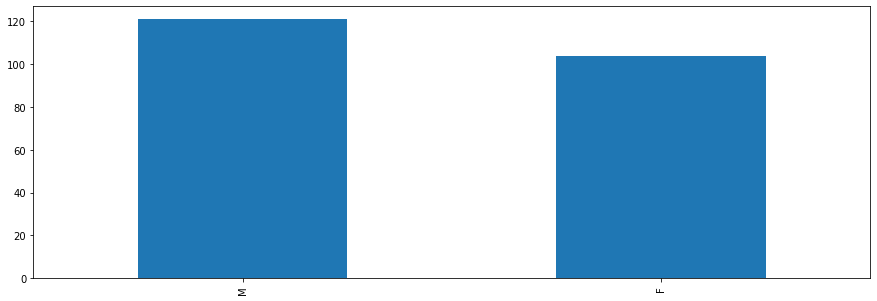

In [15]:
plot_bar(['userId'],'gender')

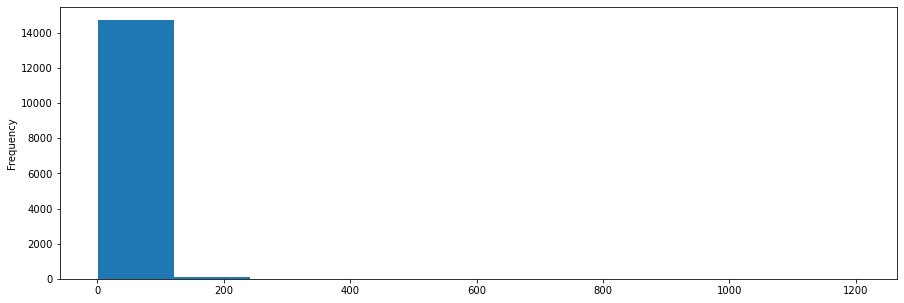

In [16]:
plot_hist([],'length')

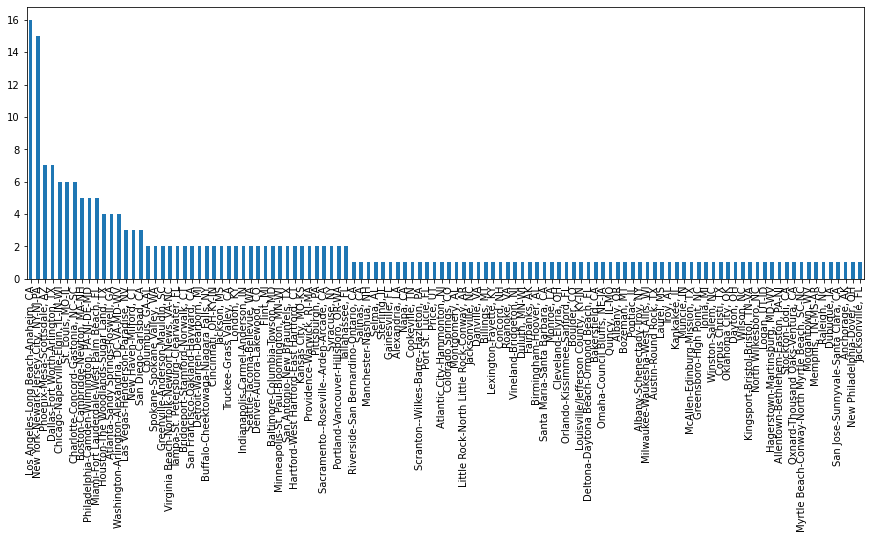

In [17]:
plot_bar(['userId'],'location')

In [18]:
# Create a US state column
df_cleand_pd['location_state']=df_cleand_pd['location'].apply(lambda x:x.split(',')[1])

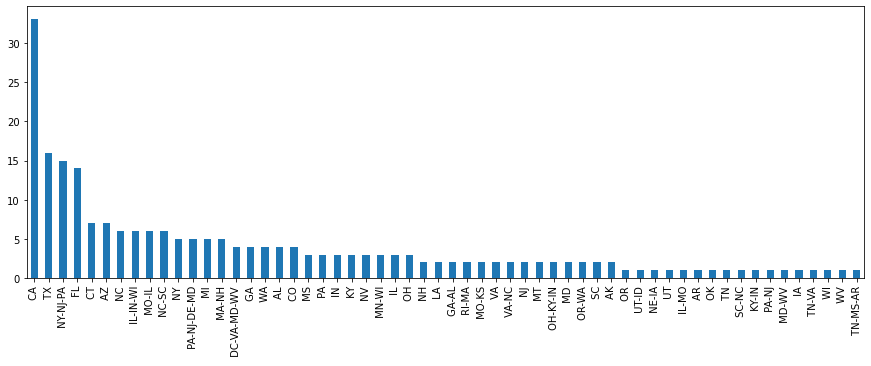

In [19]:
plot_bar(['userId'],'location_state')

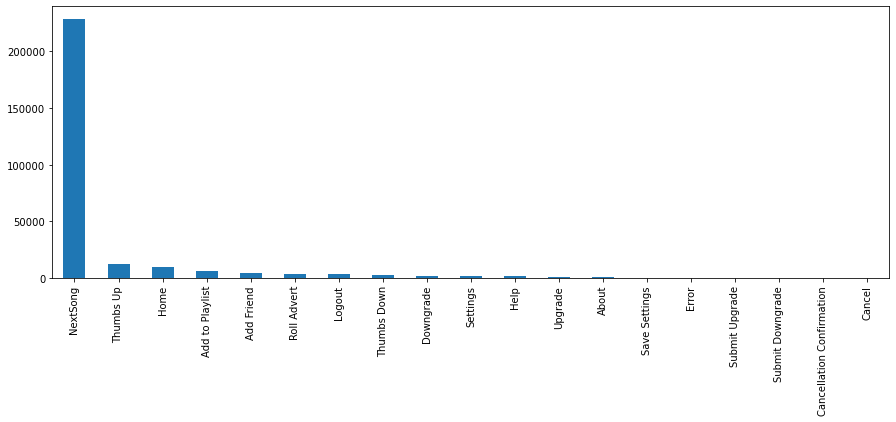

In [20]:
plot_bar([],'page')

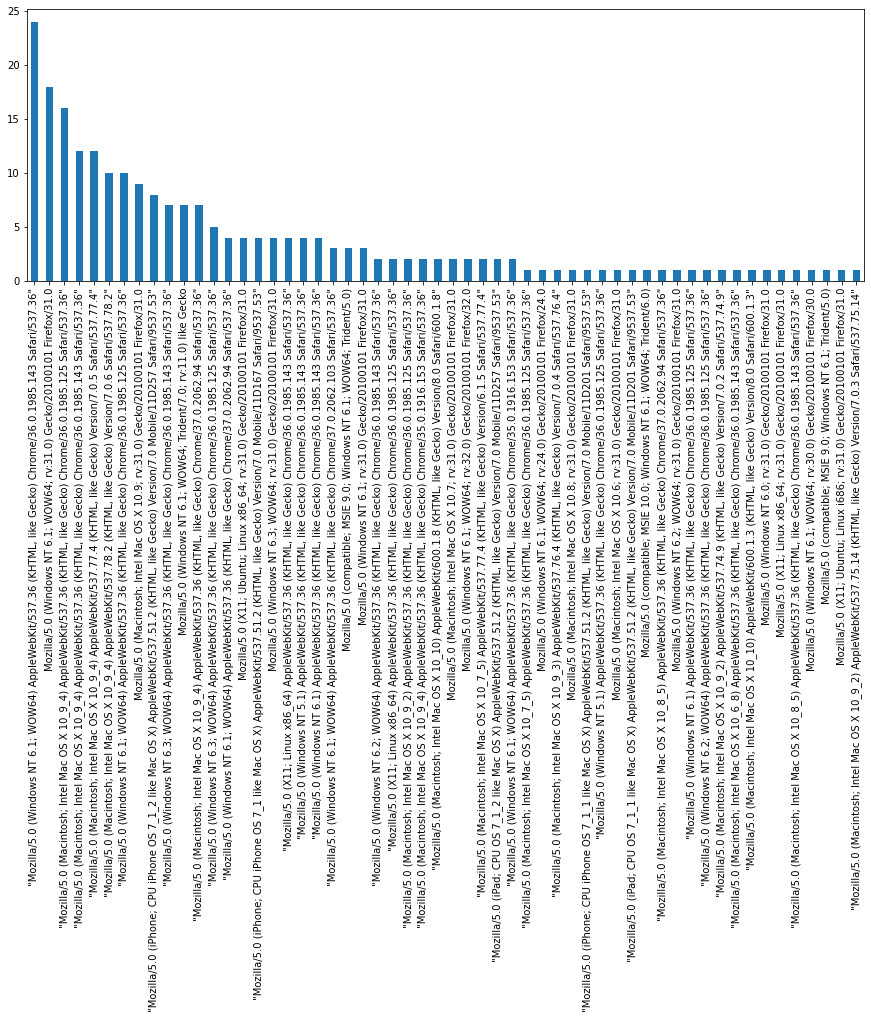

In [21]:
plot_bar(['userId'],'userAgent')

In [22]:
# Try to reduce user agent strings to distinct platforms

def platform_filter(userAgentString):
    platform_list=['Windows','Linux','iPad','iPhone','Macintosh']
    
    for platform in platform_list:
        if platform in userAgentString:
            return platform
    
    return None


df_cleand_pd['platform']=df_cleand_pd.userAgent.apply(platform_filter)

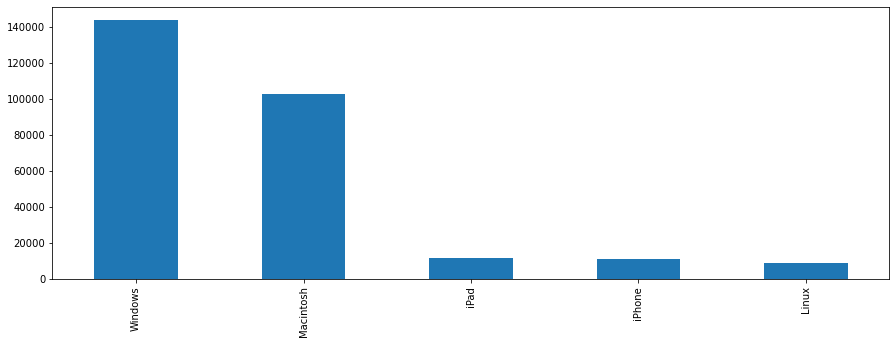

In [23]:
plot_bar([],'platform')

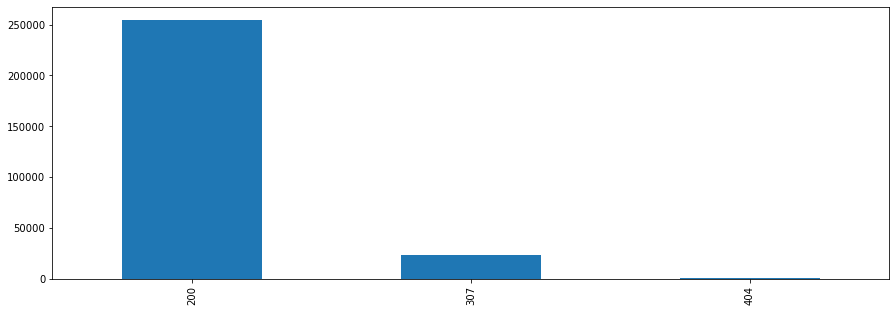

In [24]:
# HTTP status codes
plot_bar([],'status')

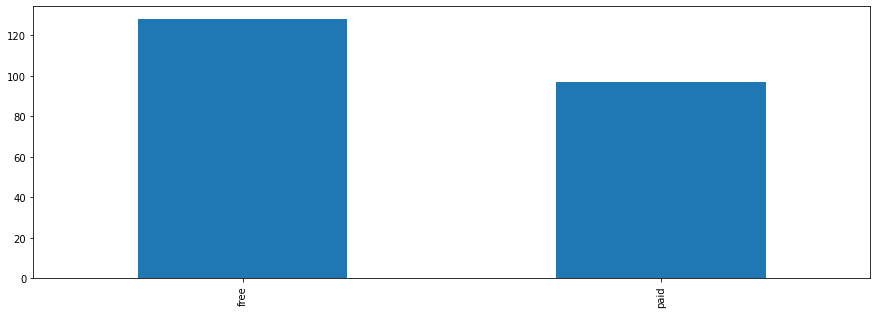

In [25]:
# Free vs. paid users
plot_bar(['userId'],'level')

In [26]:
# Time stuff ... day of week , day of month, month
df_cleand_pd['dt']=pd.to_datetime(df_cleand_pd.ts.astype('datetime64[ms]'))

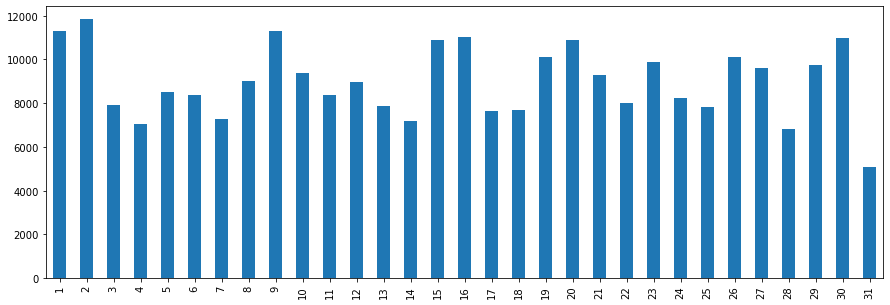

In [27]:
# Create columns for day of month/month/year/day of week/hour of day
df_cleand_pd['year']=pd.DatetimeIndex(df_cleand_pd.dt).year
df_cleand_pd['month']=pd.DatetimeIndex(df_cleand_pd.dt).month
df_cleand_pd['day']=pd.DatetimeIndex(df_cleand_pd.dt).day
df_cleand_pd['hour']=pd.DatetimeIndex(df_cleand_pd.dt).hour
df_cleand_pd['dow']=pd.DatetimeIndex(df_cleand_pd.dt).dayofweek

# Activity by day
df_cleand_pd['day'].value_counts().sort_index().plot(kind='bar',figsize=(15,5))

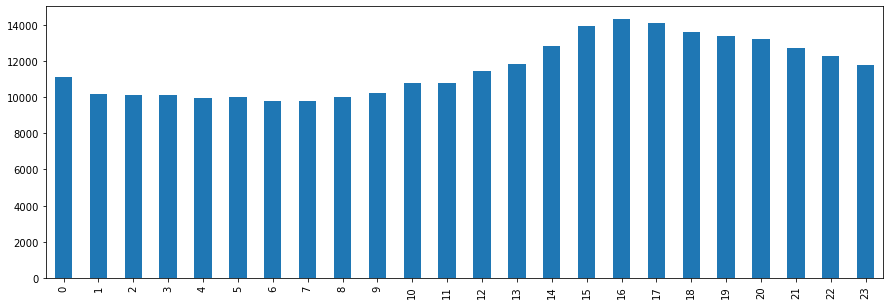

In [28]:
# Activity by hour
df_cleand_pd['hour'].value_counts().sort_index().plot(kind='bar',figsize=(15,5))

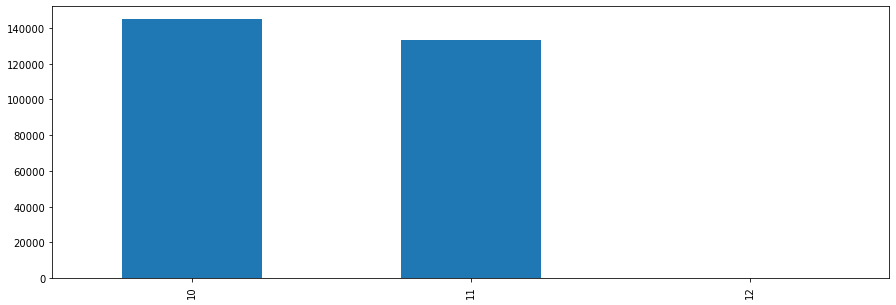

In [29]:
# Activity by month
df_cleand_pd['month'].value_counts().sort_index().plot(kind='bar',figsize=(15,5))

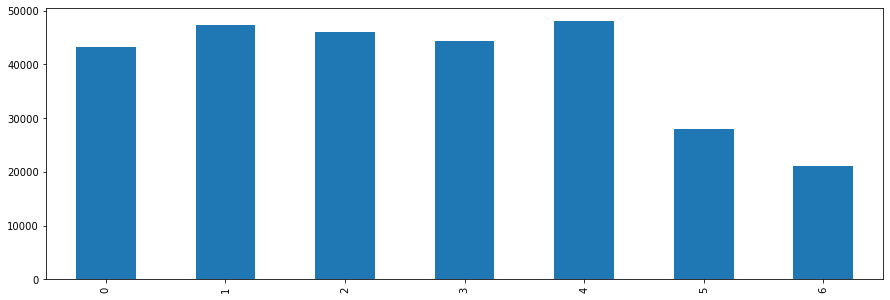

In [30]:
# Activity by week day
df_cleand_pd['dow'].value_counts().sort_index().plot(kind='bar',figsize=(15,5))

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [31]:
# Do this in PySpark because we will need to label Churn when working on large dataset...
from pyspark.sql.types import IntegerType,StringType,FloatType,BooleanType
# Use 'Cancellation confirmation' events to apply the Churn1 label
udf_churn1=udf(lambda x:True if x =='Cancellation Confirmation' else False,BooleanType())
df_clean=df_clean.withColumn('Churn1',udf_churn1(df.page))

# Use 'Downgrade' events to apply the Churn2 label
udf_churn2=udf(lambda x:True if x =='Downgrade' else False,BooleanType())
df_clean=df_clean.withColumn('Churn2',udf_churn2(df.page))

In [32]:
# Get list of churned users
churned_users=[x.userId for x in df_clean.where(df_clean.Churn1==True).select('userId').distinct().collect()]

In [33]:
# Number of churned users
len(churned_users)

52

In [34]:
# Get list of downgrade users
downgrade_users=[x.userId for x in df_clean.where(df_clean.Churn2==True).select('userId').distinct().collect()]

In [35]:
# Number of downgrade users
len(downgrade_users)

154

In [36]:
# Label each row with users who have cancelled/downgraded
df_clean2=df_clean.withColumn('Churn1',when(col('userId').isin(churned_users),True).otherwise(False))
df_clean2=df_clean2.withColumn('Churn2',when(col('userId').isin(downgrade_users),True).otherwise(False))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [37]:
df_clean2_pd=df_clean2.toPandas()
df_cleand_pd['Churn1']=df_clean2_pd['Churn1']
df_cleand_pd['Churn2']=df_clean2_pd['Churn2']

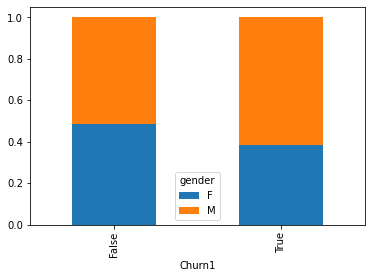

In [38]:
# Churn status gender split
tmp=df_cleand_pd.drop_duplicates('userId').groupby(['Churn1','gender']).count()['Churn2'].unstack(level=0)
churn_by_gender=(tmp)/tmp.sum()
churn_by_gender.T.plot.bar(stacked=True)

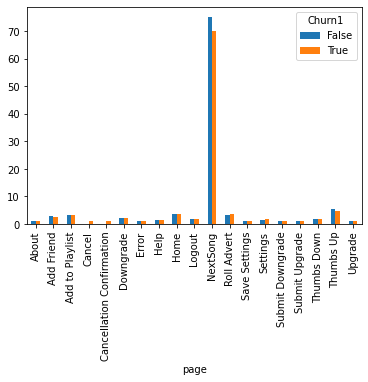

In [39]:
# Average of each page per session per user by churn status
average_visits_to_each_page_by_churn_status=df_cleand_pd.groupby(['Churn1','userId','page','sessionId']).count()['Churn2'].unstack(level=2).mean(level=0).T
average_visits_to_each_page_by_churn_status.plot.bar()

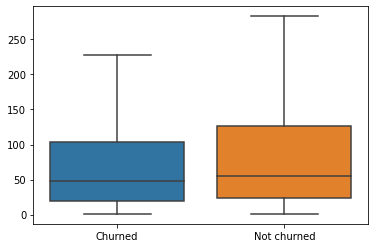

In [40]:
# Average songs per session by churn status
ave_songs_per_session=df_cleand_pd[df_cleand_pd.page=='NextSong'].groupby(['Churn1','sessionId']).count()['Churn2'].unstack(level=1).T
sns.boxplot(data= pd.DataFrame({'Churned':ave_songs_per_session[True],'Not churned':ave_songs_per_session[False]}),showfliers = False)

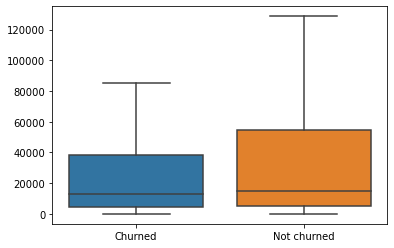

In [41]:
# Average session length in time by churn status
average_session_length_by_churn=((df_cleand_pd.groupby(['Churn1','sessionId']).ts.max()-df_cleand_pd.groupby(['Churn1','sessionId']).ts.min())/1e3).unstack().T
sns.boxplot(data= pd.DataFrame({'Churned':average_session_length_by_churn[True],'Not churned':average_session_length_by_churn[False]}),showfliers = False)

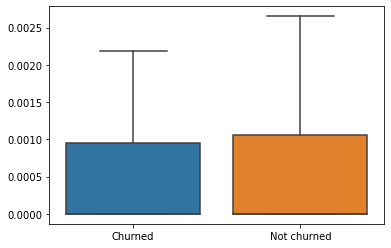

In [42]:
# Error rate (404 HTTP status) per user
error_rate_per_user=(df_cleand_pd.groupby(['Churn1','userId','status']).sum()['Churn2'].unstack(level=2)[404]/df_cleand_pd.groupby(['Churn1','userId','status']).sum()['Churn2'].unstack(level=2).sum(axis=1)).fillna(0).unstack(level=1).T
sns.boxplot(data= pd.DataFrame({'Churned':error_rate_per_user[True],'Not churned':error_rate_per_user[False]}),showfliers = False)

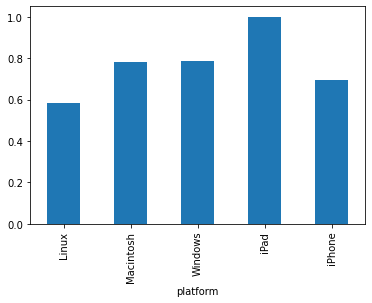

In [43]:
platform_by_churn=df_cleand_pd.drop_duplicates(subset='userId').groupby(['Churn1','userId','platform']).count()['Churn2'].unstack(level=1).sum(axis=1)
prop_platform_churn=platform_by_churn[False]/(platform_by_churn[False]+platform_by_churn[True].reindex(platform_by_churn[False].index).fillna(0))
prop_platform_churn.plot.bar()

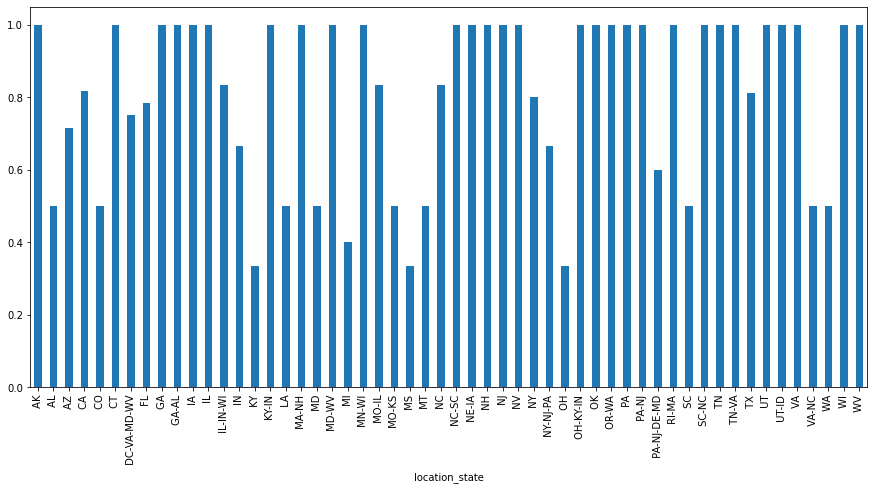

In [44]:
location_by_churn_status=df_cleand_pd.drop_duplicates('userId').groupby(['Churn1','location_state']).count()['Churn2']
location_by_churn_status_true=location_by_churn_status[True].reindex(location_by_churn_status[False].index).fillna(0)


(location_by_churn_status[False]/(location_by_churn_status_true+location_by_churn_status[False])).plot.bar(figsize=(15,7))


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [45]:
# Create a US 'state' column
udf_getstate=udf(lambda x:x.split(',')[1].strip(),StringType())
df_clean2=df_clean2.withColumn('location_state',udf_getstate(df.location))

# Generate a 'platform' column
def platform_filter(userAgentString):
    platform_list=['Windows','Linux','iPad','iPhone','Macintosh']
    
    for platform in platform_list:
        if platform in userAgentString:
            return platform
    
    return None

udf_getplatform=udf(platform_filter)
df_clean2=df_clean2.withColumn('platform',udf_getplatform(df.userAgent))

# Generate aggregates...

# Select state,platform,gender,Churn1 from df
df_features=df_clean2.dropDuplicates(subset=['userId']).select(['userId','Churn1','location_state','platform','gender'])

# Average songs per session by churn status
ave_songs_per_session=df_clean2.filter(df.page=='NextSong').groupBy(['userId','sessionId']).agg({"*": "count"}).groupBy(['userId']).agg({"count(1)": "avg"}).withColumnRenamed("avg(count(1))","ave_songs_per_session")

In [46]:
# Average session length in time by churn status
ave_session_length=df_clean2.groupBy(['userId','sessionId']).agg((f_max('ts')-f_min('ts'))/1000).groupBy(['userId']).agg({"((max(ts) - min(ts)) / 1000)":"avg"}).withColumnRenamed("avg(((max(ts) - min(ts)) / 1000))","ave_session_length")

In [47]:
# Errors (404 HTTP status) per user per session
error_rate_per_user=df_clean2.filter(df_clean2.status=='404').groupBy(['userId','sessionId']).agg({"*":"count"}).groupBy(['userId']).agg({"count(1)":"avg"}).withColumnRenamed("avg(count(1))","ave_errors_per_session")

In [48]:
# Some users have zero error rate (the server never returned a 404 for them) and are not represented in error_rate_per_user...
error_rate_per_user.count()

117

In [49]:
# Join aggregates to features table
df_features=df_features.join(ave_songs_per_session,on='userId').join(ave_session_length,on='userId').join(error_rate_per_user,on='userId',how='outer')

In [50]:
# Fill NA corresponding to 0 error rates for some users left over from join on error_rate_per_user
df_features=df_features.na.fill(0.,subset=["ave_errors_per_session"])

In [51]:
df_features.where(df_features.Churn1==True).select('userId').distinct().count()

52

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [52]:
# Encode label
udf_churnencode=udf(lambda x:1 if x else 0)
df_features = df_features.withColumn('label',udf_churnencode(df_features.Churn1))
df_features = StringIndexer(inputCol="label", outputCol="label_idx").fit(df_features).transform(df_features)
# Encode categorical feature columns
df_features = StringIndexer(inputCol="location_state", outputCol="location_state_idx").fit(df_features).transform(df_features)
df_features = StringIndexer(inputCol="platform", outputCol="platform_idx").fit(df_features).transform(df_features)     
df_features = StringIndexer(inputCol="gender", outputCol="gender_idx").fit(df_features).transform(df_features)

In [53]:
labels=df_features.toPandas()

In [54]:
labels.Churn1

0      False
1      False
2       True
3      False
4       True
       ...  
220    False
221    False
222     True
223    False
224     True
Name: Churn1, Length: 225, dtype: bool

In [55]:
df_features=df_features.drop('catFeatures','features','indexedFeatures','numFeatures','normFeatures')

In [56]:
# Vector index the categorical features columns
categorical_features = ["platform_idx","gender_idx"]

assembler = VectorAssembler(inputCols=categorical_features, outputCol='catFeatures')
features_vec = assembler.transform(df_features)

indexer = VectorIndexer(inputCol="catFeatures", outputCol="indexedFeatures")
indexerModel= indexer.fit(features_vec)
df_features = indexerModel.transform(features_vec)

In [57]:
# Scale numerical features
numerical_features = ['ave_songs_per_session','ave_session_length','ave_errors_per_session']

assembler = VectorAssembler(inputCols=numerical_features, outputCol='numfeatures')
features_vec = assembler.transform(df_features)

normalizer = Normalizer(inputCol="numfeatures", outputCol="normFeatures", p=1.0)
df_features = normalizer.transform(features_vec)

In [58]:
# Merge numerical and categorical feature vectors
assembler = VectorAssembler(inputCols=['normFeatures','indexedFeatures'], outputCol='features')
df_features = assembler.transform(df_features)

In [59]:
(training_data, test_data) = df_features.randomSplit([0.8,0.2])

In [60]:
rf = RandomForestClassifier(labelCol='label_idx',featuresCol='features')
rf_paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [3,4,5]).addGrid(rf.maxDepth, [3,5]).build()

lr = LogisticRegression(labelCol='label_idx',featuresCol='features')
lr_paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01,0.1,0.3]).addGrid(lr.maxIter, [20]).build()

dt = DecisionTreeClassifier(labelCol='label_idx',featuresCol='features',seed=5)
dt_paramGrid = ParamGridBuilder().addGrid(dt.maxBins, [32]).addGrid(dt.maxMemoryInMB,[256]).addGrid(dt.maxDepth,[3,4,5]).build()

gbt = GBTClassifier(labelCol='label_idx',featuresCol='features',maxIter = 10,seed = 38)
gbt_paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth,[3,4,5]).build()

svm = LinearSVC(labelCol='label_idx',featuresCol='features',maxIter = 10)
svm_paramGrid = ParamGridBuilder().addGrid(svm.regParam,[0.01, 0.05, 0.5]).build()

clf_and_pg=[
    #(rf,rf_paramGrid),
    (lr,lr_paramGrid),
    (dt,dt_paramGrid),
    (gbt,gbt_paramGrid),
    (svm,svm_paramGrid),
]


In [61]:
for clf,paramGrid in clf_and_pg:
    print('** '+clf.__class__.__name__+" **")

    crossval = CrossValidator(estimator=clf,estimatorParamMaps=paramGrid,evaluator=MulticlassClassificationEvaluator(labelCol='label_idx',predictionCol='prediction',metricName='f1'),numFolds=2)  # use 3+ folds in practice

    # Run cross-validation, and choose the best set of parameters.
    model = crossval.fit(training_data)

    predictions = model.transform(test_data)

    evaluator = MulticlassClassificationEvaluator(labelCol='label_idx',predictionCol='prediction',metricName='accuracy')
    accuracy = evaluator.evaluate(predictions)
    print('Accuracy ', accuracy)
    evaluator = MulticlassClassificationEvaluator(labelCol='label_idx',predictionCol='prediction',metricName='f1')
    accuracy = evaluator.evaluate(predictions)
    print('f1-score ', accuracy)

** LogisticRegression **
Accuracy  0.7142857142857143
f1-score  0.5952380952380952
** DecisionTreeClassifier **
Accuracy  0.6326530612244898
f1-score  0.5780219780219781
** GBTClassifier **
Accuracy  0.7142857142857143
f1-score  0.6527777777777779
** LinearSVC **
Accuracy  0.7142857142857143
f1-score  0.5952380952380952


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.